Generate plots for tuning SD and numsps

It is latest results until 9 Nov, 2022


### Import some useful pkgs

In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import scipy
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr

from tqdm import trange, tqdm
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from functools import partial
from easydict import EasyDict as edict
from pathlib import Path

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Reload my modules

In [3]:
import importlib
#import constants
#importlib.reload(constants)

from utils.misc import meg_psd2spatialfeature, get_mode, load_pkl, save_pkl
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from sgm.sgm import SGM
from spectrome import Brain, path, functions

from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

### Some functions

In [4]:
def _simulate_data(params, sgmmodel):
    """The function to simulate samples
    """
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params)
    psd = psd[:68, :]
    spatial_fs = spatialFs.sum(axis=1)
    
    std_psd_DB = psd_2tr(psd)
    psd_fs = std_psd_DB.flatten()
    
    res = np.concatenate([psd_fs, spatial_fs]) 
    return res

### Load real data PSD and brain

#### PSD and connectome

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values


#### data for brain plots

In [6]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(DAT_ROOT/"DK68_labelorder.xlsx")
with open(DAT_ROOT/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [7]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wU[orderedind]
    return wUreorder

with open(DAT_ROOT/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

### Set up Parameters

In [8]:
metd = edict()
metd.SBI = "SBI-SGM"
metd.anl = "Ann-SGM"

plot_sets = edict()
plot_sets.col = ["dodgerblue", "coral"]
plot_sets.alpha = 0.8
plot_sets.marker = ["o", "h"]

In [9]:
paras = edict()
paras.noise_sd = 0.2
paras.num_prior_sps = int(1e5)
paras.path = RES_ROOT/"./main_results_nsf"

paras.robustParas = edict()
paras.robustParas.num_rep = 100
paras.robustParas.noise_sd = 0.2
paras.robustParas.num_prior_sps = int(1e5)
paras.robustParas.path = Path(paras.path/"robust_results")

paras.tuningParas = edict()
paras.tuningParas.noise_sd = 0.2
paras.tuningParas.num_prior_sps = int(1e5)
paras.tuningParas.path = Path(paras.path/"tuning_results")

paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

In [10]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [11]:
prior = sutils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))

In [12]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

### Tuning parameters-the prior sample sizes

#### the results saved

In [13]:
fils = list(paras.tuningParas.path.glob("tuningParasSps_200000_sd20_*.pkl"))
tmp_sort = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmp_sort)
#paras.tuningParas.num_prior_spss = [100000]
paras.tuningParas.num_prior_spss = [200000, 100000, 50000, 25000, 12500, 6250, 3125, 1600, 800]

#### Get post PSD
(only need run once)

In [49]:
for cur_num_sps in tqdm(paras.tuningParas.num_prior_spss):
    fils = list(paras.tuningParas.path.glob(f"tuningParasSps_{cur_num_sps}_sd20_*.pkl"))
    sorted_fils = sorted(fils, key=tmp_sort)
    
    for ixfil in tqdm(sorted_fils[:]):
        cur_res = load_pkl(ixfil)
        cur_post_psds = []
        for iy in range(ind_psd.shape[-1]):
            curC = ind_conn[:, :, iy]
            curBrain = Brain.Brain()
            curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
            curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
            curBrain.connectome = curC# re-assign connectome to individual connectome
            curBrain.bi_symmetric_c()
            curBrain.reduce_extreme_dir()
            cur_sgmmodel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
            
            sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], FREQS, band="alpha")
            stdSp = stdz_vec(raw_sps.sum(axis=1))
            stdPsd = psd_2tr(ind_psd[:, :, iy]).flatten()
            curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
            cur_post = cur_res.posterior.set_default_x(curX)
            
            
            simulator_data_sp = partial(_simulate_data,  sgmmodel=cur_sgmmodel)
            simulator_data_wrapper, _ = prepare_for_sbi(simulator_data_sp, prior)
        
            print(iy)
            _, post_psd = simulate_for_sbi(simulator_data_wrapper, cur_post, 
                                num_simulations=100,
                                num_workers=50)
            cur_post_psds.append(post_psd.numpy())
            
            
            
        cur_res.cur_post_psds = cur_post_psds
        save_pkl(ixfil, cur_res, True)


  0%|                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_1.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 74 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_1.pkl



 10%|█████████████▊                                                                                                                            | 1/10 [03:22<30:24, 202.74s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_2.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_2.pkl



 20%|███████████████████████████▌                                                                                                              | 2/10 [06:39<26:35, 199.46s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_3.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_3.pkl



 30%|█████████████████████████████████████████▍                                                                                                | 3/10 [09:55<23:02, 197.57s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_4.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_4.pkl



 40%|███████████████████████████████████████████████████████▏                                                                                  | 4/10 [13:11<19:43, 197.20s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_5.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 78 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_5.pkl



 50%|█████████████████████████████████████████████████████████████████████                                                                     | 5/10 [16:29<16:26, 197.34s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_6.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_6.pkl



 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 6/10 [19:44<13:06, 196.72s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_7.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_7.pkl



 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7/10 [23:01<09:50, 196.67s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_8.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_8.pkl



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8/10 [26:17<06:32, 196.46s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_9.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 89 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 95 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 4 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_9.pkl



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9/10 [29:39<03:18, 198.21s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_10.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_10.pkl



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [32:56<00:00, 1976.99s/it]


#### Spectral and spatial features estimation

In [14]:
meg_psd_mean = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
meg_psd_each_ROIs = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])

In [15]:
numsps_corrs = dict()
numsps_roi_corrss = dict()
numsps_sgm_psd_means = dict()
for cur_num_sps in tqdm(paras.tuningParas.num_prior_spss):
    fils = list(paras.tuningParas.path.glob(f"tuningParasSps_{cur_num_sps}_sd20_*.pkl"))
    sorted_fils = sorted(fils, key=tmp_sort)
    
    corrs = []
    roi_corrss = []
    sgm_psd_means = []
    for ixfil in sorted_fils[:]:
        cur_res = load_pkl(ixfil)
        est_psds = []
        for iy in range(36):
            est_psd = np.mean(cur_res.cur_post_psds[iy][:, :-68], axis=0)
            est_psd = est_psd.reshape(68, 40)
            est_psds.append(est_psd)
            
        sgm_psd_mean_new = np.array(est_psds).mean(axis=1).mean(axis=0)
        sgm_psd_means.append(sgm_psd_mean_new)
        corr = scipy.stats.pearsonr(meg_psd_mean, sgm_psd_mean_new)[0]
        corrs.append(corr)
        
        roi_corrs = []
        for iy in range(meg_psd_each_ROIs.shape[0]):
            curMEG = meg_psd_each_ROIs[iy]
            curSGM = est_psds[iy]
            roi_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
        print(np.median(roi_corrs), np.mean(roi_corrs))
        roi_corrss.append(roi_corrs)
        
    numsps_corrs[cur_num_sps]= np.array(corrs)
    numsps_roi_corrss[cur_num_sps] = np.array(roi_corrss)
    numsps_sgm_psd_means[cur_num_sps] = sgm_psd_means

  0%|                                                                                                                                                    | 0/9 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_200000_sd20_1.pkl
0.9005193737584944 0.8907483831152282
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_200000_sd20_2.pkl
0.9002503937817752 0.8915618441486739
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_200000_sd20_3.pkl
0.8911299957708337 0.8824822767178323
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_200000_sd20_4.pkl
0.900196218499516 0.8932557602377506
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_200000_sd20_5.pkl
0.8962720820507923 0.8868945635297747
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningPara

 11%|███████████████▌                                                                                                                            | 1/9 [00:10<01:22, 10.35s/it]

0.8968034687729434 0.8831897198180774
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_1.pkl
0.8867456958783156 0.8806162120391532
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_2.pkl
0.8995146267008642 0.8875855010324488
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_3.pkl
0.9017068130130445 0.8881817962243362
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_4.pkl
0.8966315235645907 0.8830358597000313
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_100000_sd20_5.pkl
0.9001960498910272 0.8933309658714563
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/mai

 22%|███████████████████████████████                                                                                                             | 2/9 [00:19<01:09,  9.90s/it]

0.8979402181248537 0.8839620769870603
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_50000_sd20_1.pkl
0.8963775054651866 0.8893930588297896
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_50000_sd20_2.pkl
0.8927277689794941 0.8856781573329315
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_50000_sd20_3.pkl
0.8987626741694518 0.8912206934665898
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_50000_sd20_4.pkl
0.8958917182541315 0.8899206353599324
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_50000_sd20_5.pkl
0.8900576246356617 0.8797682924683874
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_res

 33%|██████████████████████████████████████████████▋                                                                                             | 3/9 [00:29<00:57,  9.67s/it]

0.8991354056847949 0.8832717620732837
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_25000_sd20_1.pkl
0.8948453396062039 0.8891728003015414
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_25000_sd20_2.pkl
0.8993095409823366 0.8909368416563507
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_25000_sd20_3.pkl
0.8957884267132725 0.888055861697588
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_25000_sd20_4.pkl
0.8949769920106558 0.8913378850018923
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_25000_sd20_5.pkl
0.894943642326675 0.8899748068160444
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_resul

 44%|██████████████████████████████████████████████████████████████▏                                                                             | 4/9 [00:38<00:46,  9.35s/it]

0.8921621772150679 0.886435222816072
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_12500_sd20_1.pkl
0.8975705302224164 0.8890104742224472
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_12500_sd20_2.pkl
0.8969145775196836 0.8917071380369495
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_12500_sd20_3.pkl
0.8910325503669041 0.884922322285213
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_12500_sd20_4.pkl
0.8997333595575858 0.8914691268334308
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_12500_sd20_5.pkl
0.8966795476190442 0.8866941461589524
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_resul

 56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 5/9 [00:47<00:36,  9.21s/it]

0.894742815923582 0.8872438420400197
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_6250_sd20_1.pkl
0.8903499958655156 0.8858005467116794
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_6250_sd20_2.pkl
0.8944319902594537 0.889927135718356
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_6250_sd20_3.pkl
0.893220993098807 0.8897487840101229
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_6250_sd20_4.pkl
0.898072853058776 0.8858694437739322
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_6250_sd20_5.pkl
0.8991597603176278 0.8931443980662862
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6/9 [00:56<00:27,  9.09s/it]

0.8975964460299903 0.8925829131475638
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_3125_sd20_1.pkl
0.897643635610311 0.8904491626374151
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_3125_sd20_2.pkl
0.8957377056025075 0.8905717798237155
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_3125_sd20_3.pkl
0.8946420280481064 0.8901729002370343
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_3125_sd20_4.pkl
0.8977935270478044 0.8918844414538167
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_3125_sd20_5.pkl
0.8922456986388264 0.8872651965575212
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_n

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7/9 [01:06<00:18,  9.41s/it]

0.8952977244814555 0.8876041997976656
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_1600_sd20_1.pkl
0.8967084036788089 0.8890216100623358
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_1600_sd20_2.pkl
0.89537816091472 0.889920892993709
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_1600_sd20_3.pkl
0.8990058341247452 0.8928453016512354
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_1600_sd20_4.pkl
0.8991517538744497 0.8932410061189491
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_1600_sd20_5.pkl
0.8993866833970008 0.8920851924822253
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8/9 [01:15<00:09,  9.40s/it]

0.8987597318700702 0.890927362483429
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_800_sd20_1.pkl
0.8977316185299946 0.8915171974762013
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_800_sd20_2.pkl
0.8978613209510533 0.8906240363749376
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_800_sd20_3.pkl
0.892695471232412 0.8853669716559721
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_800_sd20_4.pkl
0.8968638339769177 0.8909061671391945
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSps_800_sd20_5.pkl
0.8934901533999045 0.8858599993698056
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tun

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:25<00:00,  9.53s/it]

0.8975911691156659 0.8906790764665617


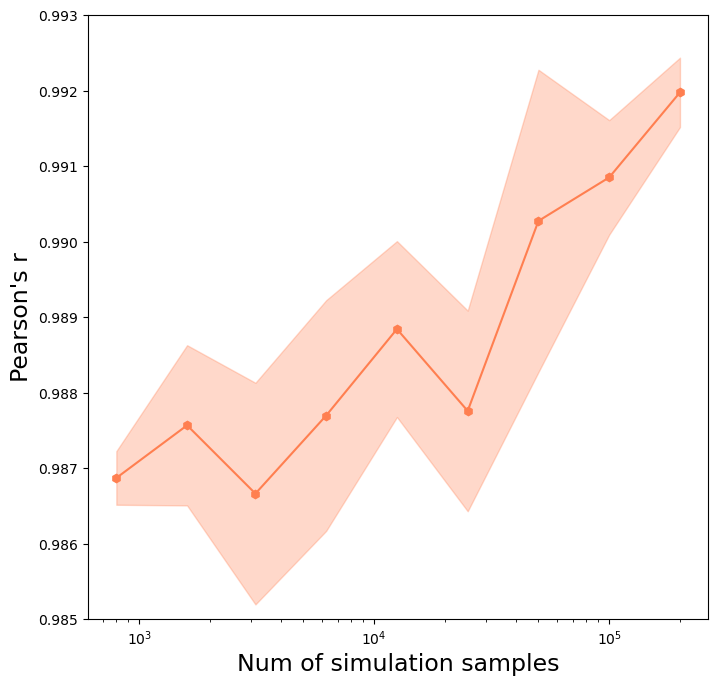

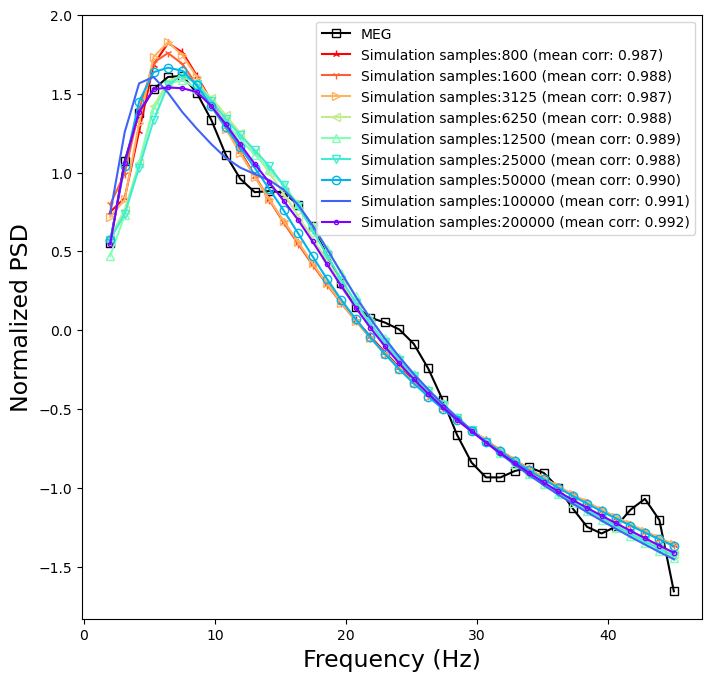

In [17]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
all_markers = list(Line2D.markers.keys())
all_cols = cm.rainbow(np.linspace(0, 1, len(paras.tuningParas.num_prior_spss)))

mean_idxs = []
corrs_mean = []
corrs_se = []
for cur_num_sps in paras.tuningParas.num_prior_spss:
    corrs = numsps_corrs[cur_num_sps]
    mean_idxs.append(np.argmin(np.abs(corrs - np.mean(corrs))))
    corrs_mean.append(np.mean(corrs))
    corrs_se.append(np.std(corrs)/np.sqrt(10))
    
mean_idxs = np.array(mean_idxs)
corrs_mean = np.array(corrs_mean)
corrs_se = np.array(corrs_se)
    
lows = corrs_mean - 1.96*corrs_se
ups = corrs_mean + 1.96*corrs_se

plt.figure(figsize=[8, 8], dpi=100)
plt.plot(paras.tuningParas.num_prior_spss, corrs_mean, "-", 
         marker=plot_sets.marker[1], color=plot_sets.col[1])
plt.fill_between(paras.tuningParas.num_prior_spss, lows, ups, color=plot_sets.col[1], alpha=0.3)
plt.xscale("log")
plt.ylim([0.985, 0.993])
plt.xlabel("Num of simulation samples", fontsize=17)
_ = plt.ylabel("Pearson's r", fontsize=17)
plt.savefig(FIG_ROOT/"tuningSps_overall_PSDcorr.jpg")

plt.figure(figsize=[8, 8], dpi=100)
plt.plot(FREQS, stdz_vec(meg_psd_mean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', label = "MEG")
for ix in range(len(paras.tuningParas.num_prior_spss)-1, -1, -1):
    cur_num_sps = paras.tuningParas.num_prior_spss[ix]
    mean_idx = mean_idxs[ix]
    label=f"Simulation samples:{cur_num_sps} (mean corr: {corrs_mean[ix]:.3f})"
    plt.plot(FREQS, 
             stdz_vec(numsps_sgm_psd_means[cur_num_sps][mean_idx]), 
             #stdz_vec(np.mean(numsps_sgm_psd_means[cur_num_sps], axis=0)), 
             linestyle = '-',marker=all_markers[ix] ,
             fillstyle = 'none',color=all_cols[ix], label=label)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/"tuningSps_overall_PSDs.jpg")

In [94]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 50.21it/s]


### Tuning parameters-the noise sd

#### the results saved

In [18]:
fils = list(paras.tuningParas.path.glob("tuningParasSd_*.pkl"))
def tmp_sort(p): 
    sd, idx = p.stem.split("sd")[-1].split("_")
    sd, idx = int(sd), int(idx)
    value = sd - idx
    return -value
sorted_fils = sorted(fils, key=tmp_sort)
paras.tuningParas.noise_sds = [1.6, 0.8, 0.4, 0.3, 0.2]

#### post PSD

(only once)

In [ ]:
for ixfil in tqdm(sorted_fils[:]):
    cur_res = load_pkl(ixfil)
    cur_post_psds = []
    for iy in range(ind_psd.shape[-1]):
            curC = ind_conn[:, :, iy]
            curBrain = Brain.Brain()
            curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
            curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
            curBrain.connectome = curC# re-assign connectome to individual connectome
            curBrain.bi_symmetric_c()
            curBrain.reduce_extreme_dir()
            cur_sgmmodel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
            
            sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], FREQS, band="alpha")
            stdSp = stdz_vec(raw_sps.sum(axis=1))
            stdPsd = psd_2tr(ind_psd[:, :, iy]).flatten()
            curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
            cur_post = cur_res.posterior.set_default_x(curX)
            
            
            simulator_data_sp = partial(_simulate_data,  sgmmodel=cur_sgmmodel)
            simulator_data_wrapper, _ = prepare_for_sbi(simulator_data_sp, prior)
        
            print(iy)
            _, post_psd = simulate_for_sbi(simulator_data_wrapper, cur_post, 
                                num_simulations=100,
                                num_workers=50)
            cur_post_psds.append(post_psd.numpy())
            
            
            
    cur_res.cur_post_psds = cur_post_psds
    save_pkl(ixfil, cur_res, True)


#### Check PSD

In [19]:
meg_psd_mean = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
meg_psd_each_ROIs = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])

In [20]:
sd_corrs = dict()
sd_roi_corrss = dict()
sd_sgm_psd_means = dict()
for cur_sd in tqdm(paras.tuningParas.noise_sds):
    fils = list(paras.tuningParas.path.glob(f"tuningParasSd_100000_sd{cur_sd*100:.0f}_*.pkl"))
    sorted_fils = sorted(fils, key=tmp_sort)
    
    corrs = []
    roi_corrss = []
    sgm_psd_means = []
    for ixfil in sorted_fils[:]:
        cur_res = load_pkl(ixfil)
        est_psds = []
        for iy in range(36):
            est_psd = np.mean(cur_res.cur_post_psds[iy][:, :-68], axis=0)
            est_psd = est_psd.reshape(68, 40)
            est_psds.append(est_psd)
            
        sgm_psd_mean_new = np.array(est_psds).mean(axis=1).mean(axis=0)
        sgm_psd_means.append(sgm_psd_mean_new)
        corr = scipy.stats.pearsonr(meg_psd_mean, sgm_psd_mean_new)[0]
        corrs.append(corr)
        
        roi_corrs = []
        for iy in range(meg_psd_each_ROIs.shape[0]):
            curMEG = meg_psd_each_ROIs[iy]
            curSGM = est_psds[iy]
            roi_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
        print(np.median(roi_corrs), np.mean(roi_corrs))
        roi_corrss.append(roi_corrs)
        
    sd_corrs[cur_sd]= np.array(corrs)
    sd_roi_corrss[cur_sd] = np.array(roi_corrss)
    sd_sgm_psd_means[cur_sd] = sgm_psd_means

  0%|                                                                                                                                                    | 0/5 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd160_1.pkl
0.9035757675166917 0.8982430727340484
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd160_2.pkl
0.9026821337538804 0.8974633131764382
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd160_3.pkl
0.9039888195382029 0.8985670737958414
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd160_4.pkl
0.901822541553204 0.8987532984867309
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd160_5.pkl
0.9037409651422876 0.897348048321597
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParas

 20%|████████████████████████████                                                                                                                | 1/5 [00:09<00:38,  9.65s/it]

0.9024938291252701 0.8977760337337537
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd80_1.pkl
0.9038607090707844 0.8971345228973368
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd80_2.pkl
0.9042162310685157 0.8971307188778626
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd80_3.pkl
0.9053071854956198 0.8982867719371086
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd80_4.pkl
0.9022060334735378 0.8969914976709491
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd80_5.pkl
0.9036987240586022 0.89907899058039
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_resul

 40%|████████████████████████████████████████████████████████                                                                                    | 2/5 [00:19<00:29,  9.76s/it]

0.904170010766759 0.8981932565260407
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd40_1.pkl
0.9016619344746563 0.8961198837995702
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd40_2.pkl
0.9011287290595527 0.8955896902891607
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd40_3.pkl
0.90326550235114 0.8950784664656213
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd40_4.pkl
0.9035730277572416 0.8950164419849441
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd40_5.pkl
0.9036235486375472 0.8965805183805509
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_result

 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 3/5 [00:28<00:19,  9.54s/it]

0.9037425073506153 0.8970263041460684
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd30_1.pkl
0.9023683769221067 0.8937627968605203
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd30_2.pkl
0.9022327316712967 0.8938701397459029
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd30_3.pkl
0.8984791127325351 0.8892113393230789
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd30_4.pkl
0.9004570506698752 0.8942575211569969
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd30_5.pkl
0.9027307351545988 0.8958596783315728
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_res

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4/5 [00:38<00:09,  9.53s/it]

0.8974450779033465 0.8857490515071802
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd20_1.pkl
0.8905928171516545 0.8811323527451737
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd20_2.pkl
0.8997933362220158 0.8880057273465156
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd20_3.pkl
0.8989395150477005 0.8881557868452816
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd20_4.pkl
0.8948661245655526 0.8846825904902919
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/tuning_results/tuningParasSd_100000_sd20_5.pkl
0.8994385922337262 0.894036842355169
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_resu

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.46s/it]

0.8977940705987135 0.8839856623847966


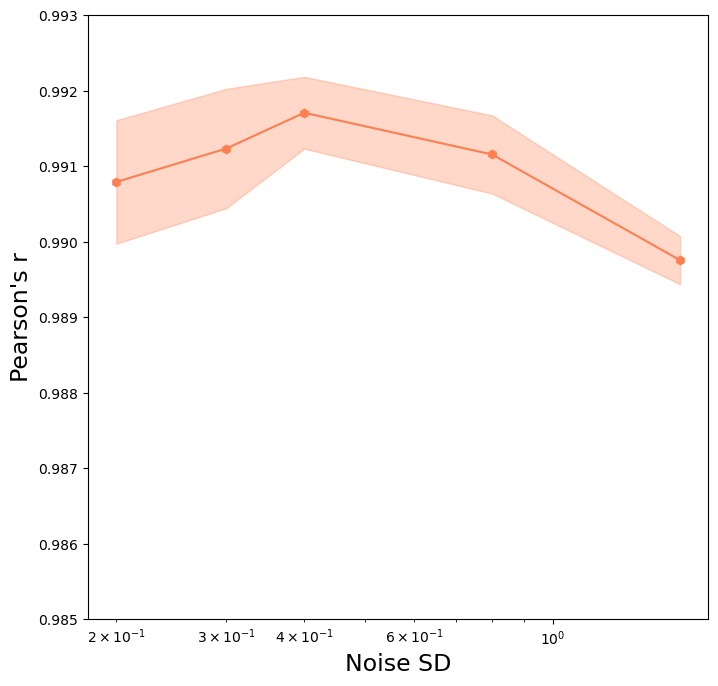

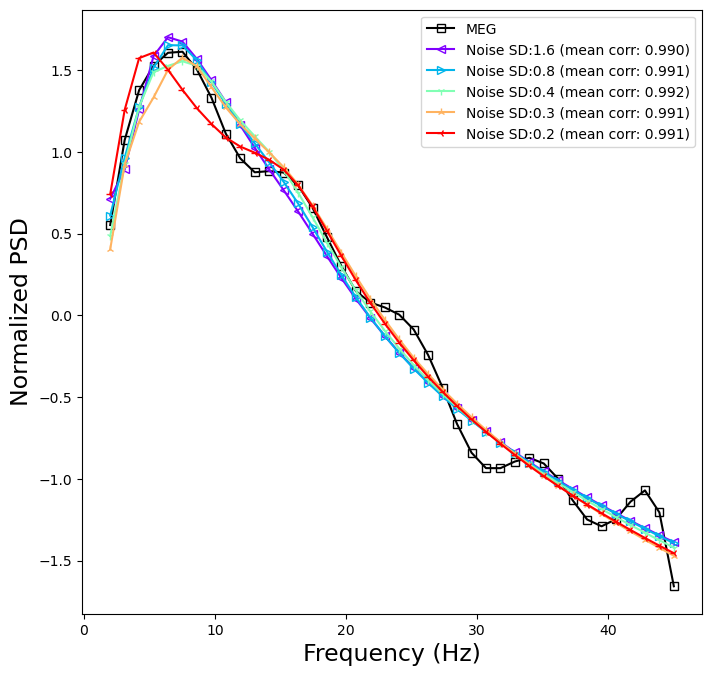

In [22]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
all_markers = list(Line2D.markers.keys())[5:]
all_cols = cm.rainbow(np.linspace(0, 1, 5))

mean_idxs = []
corrs_mean = []
corrs_se = []
for cur_sd in paras.tuningParas.noise_sds:
    corrs = sd_corrs[cur_sd]
    mean_idxs.append(np.argmin(np.abs(corrs - np.mean(corrs))))
    corrs_mean.append(np.mean(corrs))
    corrs_se.append(np.std(corrs)/np.sqrt(10))
    
mean_idxs = np.array(mean_idxs)
corrs_mean = np.array(corrs_mean)
corrs_se = np.array(corrs_se)

lows = corrs_mean - 1.96*corrs_se
ups = corrs_mean + 1.96*corrs_se


plt.figure(figsize=[8, 8], dpi=100)
plt.plot(paras.tuningParas.noise_sds, corrs_mean, "-", 
         marker=plot_sets.marker[1], color=plot_sets.col[1])
plt.fill_between(paras.tuningParas.noise_sds, lows, ups, color=plot_sets.col[1], alpha=0.3)
plt.xscale("log")
plt.xlabel("Noise SD", fontsize=17)
plt.ylim([0.985, 0.993])
_ = plt.ylabel("Pearson's r", fontsize=17)
plt.savefig(FIG_ROOT/"tuningSD_overall_PSDcorr.jpg")

plt.figure(figsize=[8, 8], dpi=100)
plt.plot(FREQS, stdz_vec(meg_psd_mean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', label = "MEG")
#for ix in [4]:
for ix in range(len(paras.tuningParas.noise_sds)):
    cur_sd = paras.tuningParas.noise_sds[ix]
    mean_idx = mean_idxs[ix]
    label=f"Noise SD:{cur_sd} (mean corr: {corrs_mean[ix]:.3f})"
    plt.plot(FREQS, 
             stdz_vec(sd_sgm_psd_means[cur_sd][mean_idx]), 
             linestyle = '-',marker=all_markers[ix] ,
             fillstyle = 'none',color=all_cols[ix], label=label)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/"tuningSD_overall_PSDs.jpg")